In [1]:
from kaggle_secrets import UserSecretsClient
secret_label = "Token"
token = UserSecretsClient().get_secret(secret_label)

! git clone https://{token}@github.com/CarloSgaravatti/Recsys_Challenge_2023.git

Cloning into 'Recsys_Challenge_2023'...
remote: Enumerating objects: 4405, done.
remote: Counting objects: 100% (1351/1351), done.
remote: Compressing objects: 100% (539/539), done.
remote: Total 4405 (delta 909), reused 1181 (delta 798), pack-reused 3054
Receiving objects: 100% (4405/4405), 2.55 GiB | 23.31 MiB/s, done.
Resolving deltas: 100% (3391/3391), done.
Updating files: 100% (446/446), done.


In [2]:
! pip install PyGithub requests

  Obtaining dependency information for PyGithub from https://files.pythonhosted.org/packages/be/04/810d131be173cba445d3658a45512b2b2b3d0960d52c4a300d6ec5e00f52/PyGithub-2.1.1-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 856.7/856.7 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.9/302.9 kB 27.4 MB/s eta 0:00:00


In [3]:
! cd /kaggle/working/Recsys_Challenge_2023 && python run_compile_all_cython.py

run_compile_all_cython: Found 10 Cython files in 4 folders...
run_compile_all_cython: All files will be compiled using your current python environment: '/opt/conda/bin/python'
Compiling [1/10]: MatrixFactorizationImpressions_Cython_Epoch.pyx... 
In file included from /opt/conda/lib/python3.10/site-packages/numpy/core/include/numpy/ndarraytypes.h:1940,
                 from /opt/conda/lib/python3.10/site-packages/numpy/core/include/numpy/ndarrayobject.h:12,
                 from /opt/conda/lib/python3.10/site-packages/numpy/core/include/numpy/arrayobject.h:5,
                 from MatrixFactorizationImpressions_Cython_Epoch.c:1109:
/opt/conda/lib/python3.10/site-packages/numpy/core/include/numpy/npy_1_7_deprecated_api.h:17:2: warning: #warning "Using deprecated NumPy API, disable it with " "#define NPY_NO_DEPRECATED_API NPY_1_7_API_VERSION" [-Wcpp]
   17 | #warning "Using deprecated NumPy API, disable it with " \
      |  ^~~~~~~
MatrixFactorizationImpressions_Cython_Epoch.c: In functio

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import json
import random
import tqdm
import gc
import time
import os
import shutil
import optuna
import scipy.sparse as sps
from concurrent.futures import ThreadPoolExecutor

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/recommender-system-2023-challenge-polimi/data_train.csv
/kaggle/input/recommender-system-2023-challenge-polimi/data_target_users_test.csv


In [5]:
%cd /kaggle/working/Recsys_Challenge_2023

/kaggle/working/Recsys_Challenge_2023


In [6]:
from Recommenders.KNN.UserKNNCFRecommender import UserKNNCFRecommender
from Data_manager.split_functions.split_train_validation_random_holdout import split_train_in_two_percentage_global_sample
from Recommenders.SLIM.SLIMElasticNetRecommender import MultiThreadSLIM_SLIMElasticNetRecommender, SLIMElasticNetRecommender
from Evaluation.Evaluator import EvaluatorHoldout
from Recommenders.MatrixFactorization.IALSRecommender import IALSRecommender
from Recommenders.MatrixFactorization.PureSVDRecommender import PureSVDRecommender, PureSVDItemRecommender, ScaledPureSVDRecommender
from Recommenders.KNN.ItemKNNCFRecommender import ItemKNNCFRecommender
from Recommenders.KNN.UserKNNCFRecommender import UserKNNCFRecommender
from Recommenders.KNN.ItemKNNSimilarityHybridRecommender import ItemKNNSimilarityHybridRecommender
from Recommenders.KNN.ItemKNNCustomSimilarityRecommender import ItemKNNCustomSimilarityRecommender
from Recommenders.EASE_R.EASE_R_Recommender import EASE_R_Recommender
from Recommenders.Neural.MultVAERecommender import MultVAERecommender
from Recommenders.GraphBased.RP3betaRecommender import RP3betaRecommender
from Recommenders.GraphBased.P3alphaRecommender import P3alphaRecommender
from Recommenders.SLIM.SLIM_BPR_Python import SLIM_BPR_Python
from Recommenders.MatrixFactorization.NMFRecommender import NMFRecommender
from Recommenders.BaseRecommender import BaseRecommender

from Recommenders.Hybrid.LinearCombinationRecommender import LinearCombinationRecommender
from Data_manager.CrossValidationSplitter import CrossValidationSplitter

np.int = int
np.random.seed(42)
np.bool = bool
np.float = float

In [7]:
from github import Github
from github import Auth

auth = Auth.Token(token)
g = Github(auth=auth)

repo = None
for r in g.get_user().get_repos():
    if r.name == 'Recsys_Challenge_2023':
        repo = r
        print('Repository found')

Repository found


In [8]:
def upload_file(filepath_kaggle, filepath_github, commit_message):
    try:
        contents = repo.get_contents(filepath_github)
        with open(filepath_kaggle, "rb") as file:
            repo.update_file(contents.path, commit_message, file.read(), contents.sha)
    except Exception:
        with open(filepath_kaggle, "rb") as file:
            repo.create_file(filepath_github, commit_message, file.read())

In [9]:
config = {
    'tune_parameters': True,
    'database_path': '/kaggle/working/tuning_hybrid_linear_comb.db',
    'copy_prev_tuning_db': True,
    'copy_prev_best_params': True,
    'save_github': True
}

In [10]:
train_data = pd.read_csv('/kaggle/input/recommender-system-2023-challenge-polimi/data_train.csv')
user_ids_test = pd.read_csv('/kaggle/input/recommender-system-2023-challenge-polimi/data_target_users_test.csv')

In [11]:
URM_all = sps.csr_matrix((train_data.data.values,
                          ((train_data.row - 1).values, (train_data.col - 1).values)),
                        shape=(train_data.row.max(), train_data.col.max()))
URM_all

<13024x22347 sparse matrix of type '<class 'numpy.float64'>'
	with 478730 stored elements in Compressed Sparse Row format>

In [12]:
URM_train, URM_test_complete = split_train_in_two_percentage_global_sample(URM_all, train_percentage = 0.8)
URM_validation, URM_test = split_train_in_two_percentage_global_sample(URM_test_complete, train_percentage = 0.8)

# 5 Folds

In [13]:
folds = []

for i in tqdm.auto.tqdm(range(5)):
    fold_dict = {}
    fold_dict['URM_train'] = sps.load_npz(f'/kaggle/working/Recsys_Challenge_2023/models/5Folds/fold_{i}/URM_train.npz')
    fold_dict['URM_valid'] = sps.load_npz(f'/kaggle/working/Recsys_Challenge_2023/models/5Folds/fold_{i}/URM_valid.npz')
    fold_dict['Evaluator'] = EvaluatorHoldout(fold_dict['URM_valid'], cutoff_list=[10])
    
    recommender_item = ItemKNNCFRecommender(fold_dict['URM_train'])
    recommender_item.load_model(
        f'/kaggle/working/Recsys_Challenge_2023/models/5Folds/fold_{i}', 'item_knn.zip')
    fold_dict['ItemKNN'] = recommender_item

    recommender_user = UserKNNCFRecommender(fold_dict['URM_train'])
    recommender_user.load_model(
        f'/kaggle/working/Recsys_Challenge_2023/models/5Folds/fold_{i}', 'user_knn.zip')
    fold_dict['UserKNN'] = recommender_user

    recommender_rp3 = RP3betaRecommender(fold_dict['URM_train'])
    recommender_rp3.load_model(
        f'/kaggle/working/Recsys_Challenge_2023/models/5Folds/fold_{i}', 'rp3.zip')
    fold_dict['RP3'] = recommender_rp3

    recommender_p3a = P3alphaRecommender(fold_dict['URM_train'])
    recommender_p3a.load_model(
        f'/kaggle/working/Recsys_Challenge_2023/models/5Folds/fold_{i}', 'p3a.zip')
    fold_dict['P3alpha'] = recommender_p3a

    recommender_pure_svd = PureSVDRecommender(fold_dict['URM_train'])
    recommender_pure_svd.load_model(
        f'/kaggle/working/Recsys_Challenge_2023/models/5Folds/fold_{i}', 'pure_svd.zip')
    fold_dict['PureSVD'] = recommender_pure_svd

    recommender_pure_svd_item = PureSVDItemRecommender(fold_dict['URM_train'])
    recommender_pure_svd_item.load_model(
        f'/kaggle/working/Recsys_Challenge_2023/models/5Folds/fold_{i}', 'item_pure_svd.zip')
    fold_dict['PureSVDItem'] = recommender_pure_svd_item

    recommender_scaled_svd = ScaledPureSVDRecommender(fold_dict['URM_train'])
    recommender_scaled_svd.load_model(
        f'/kaggle/working/Recsys_Challenge_2023/models/5Folds/fold_{i}', 'pure_svd_scaled.zip')
    fold_dict['ScaledPureSVD'] = recommender_scaled_svd

    recommender_nmf = NMFRecommender(fold_dict['URM_train'])
    recommender_nmf.load_model(
        f'/kaggle/working/Recsys_Challenge_2023/models/5Folds/fold_{i}', 'nmf.zip')
    fold_dict['NMF'] = recommender_nmf

    recommender_slim_bpr = SLIM_BPR_Python(fold_dict['URM_train'])
    recommender_slim_bpr.load_model(
        f'/kaggle/working/Recsys_Challenge_2023/models/5Folds/fold_{i}', 'slim_bpr.zip')
    fold_dict['SlimBPR'] = recommender_slim_bpr

    recommender_slim = SLIMElasticNetRecommender(fold_dict['URM_train'])
    recommender_slim.load_model(
        f'/kaggle/working/Recsys_Challenge_2023/models/5Folds/fold_{i}', 'slim_elastic.zip')
    fold_dict['SlimElastic'] = recommender_slim
    
    recommender_ease_r = EASE_R_Recommender(fold_dict['URM_train'])
    recommender_ease_r.load_model(
        f'/kaggle/working/Recsys_Challenge_2023/models/5Folds/fold_{i}', 'ease_r.zip')
    fold_dict['EaseR'] = recommender_ease_r   
    
    folds.append(fold_dict)

  0%|          | 0/5 [00:00<?, ?it/s]

EvaluatorHoldout: Ignoring 2558 (19.6%) Users that have less than 1 test interactions
ItemKNNCFRecommender: URM Detected 609 ( 4.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 241 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: Loading model from file '/kaggle/working/Recsys_Challenge_2023/models/5Folds/fold_0item_knn.zip'
ItemKNNCFRecommender: Loading complete
UserKNNCFRecommender: URM Detected 609 ( 4.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 241 ( 1.1%) items with no interactions.
UserKNNCFRecommender: Loading model from file '/kaggle/working/Recsys_Challenge_2023/models/5Folds/fold_0user_knn.zip'
UserKNNCFRecommender: Loading complete
RP3betaRecommender: URM Detected 609 ( 4.7%) users with no interactions.
RP3betaRecommender: URM Detected 241 ( 1.1%) items with no interactions.
RP3betaRecommender: Loading model from file '/kaggle/working/Recsys_Challenge_2023/models/5Folds/fold_0rp3.zip'
RP3betaRecommender: Loading complete
P3a

In [14]:
recommenders_labels = [
    'SlimElastic', 'ItemKNN', 'RP3', 'P3alpha', 'EaseR', 'UserKNN',
    'PureSVD', 'PureSVDItem', 'ScaledPureSVD', 'NMF', 'SlimBPR'
]

In [15]:
recommenders_map = {rec_lb: [] for rec_lb in recommenders_labels}

for fold in tqdm.auto.tqdm(folds):

    for recommender in recommenders_labels:
        result_df, _ = fold['Evaluator'].evaluateRecommender(fold[recommender])
        recommenders_map[recommender].append(result_df.loc[10, 'MAP'])

recommenders_map = pd.DataFrame(recommenders_map, index=[f'fold_{i}' for i in range(len(folds))])

  0%|          | 0/5 [00:00<?, ?it/s]

EvaluatorHoldout: Processed 10466 (100.0%) in 12.65 sec. Users per second: 827
EvaluatorHoldout: Processed 10466 (100.0%) in 9.05 sec. Users per second: 1157
EvaluatorHoldout: Processed 10466 (100.0%) in 9.07 sec. Users per second: 1154
EvaluatorHoldout: Processed 10466 (100.0%) in 8.94 sec. Users per second: 1170
EvaluatorHoldout: Processed 10466 (100.0%) in 13.92 sec. Users per second: 752
EvaluatorHoldout: Processed 10466 (100.0%) in 12.83 sec. Users per second: 816
EvaluatorHoldout: Processed 10466 (100.0%) in 10.69 sec. Users per second: 979
EvaluatorHoldout: Processed 10466 (100.0%) in 14.21 sec. Users per second: 736
EvaluatorHoldout: Processed 10466 (100.0%) in 13.35 sec. Users per second: 784
EvaluatorHoldout: Processed 10466 (100.0%) in 11.15 sec. Users per second: 939
EvaluatorHoldout: Processed 10466 (100.0%) in 9.91 sec. Users per second: 1056
EvaluatorHoldout: Processed 10472 (100.0%) in 12.47 sec. Users per second: 840
EvaluatorHoldout: Processed 10472 (100.0%) in 8.89 s

In [16]:
mean_map = recommenders_map.mean()
conf_intervals = recommenders_map.apply(lambda col: np.std(col) * 1.96 / len(folds))

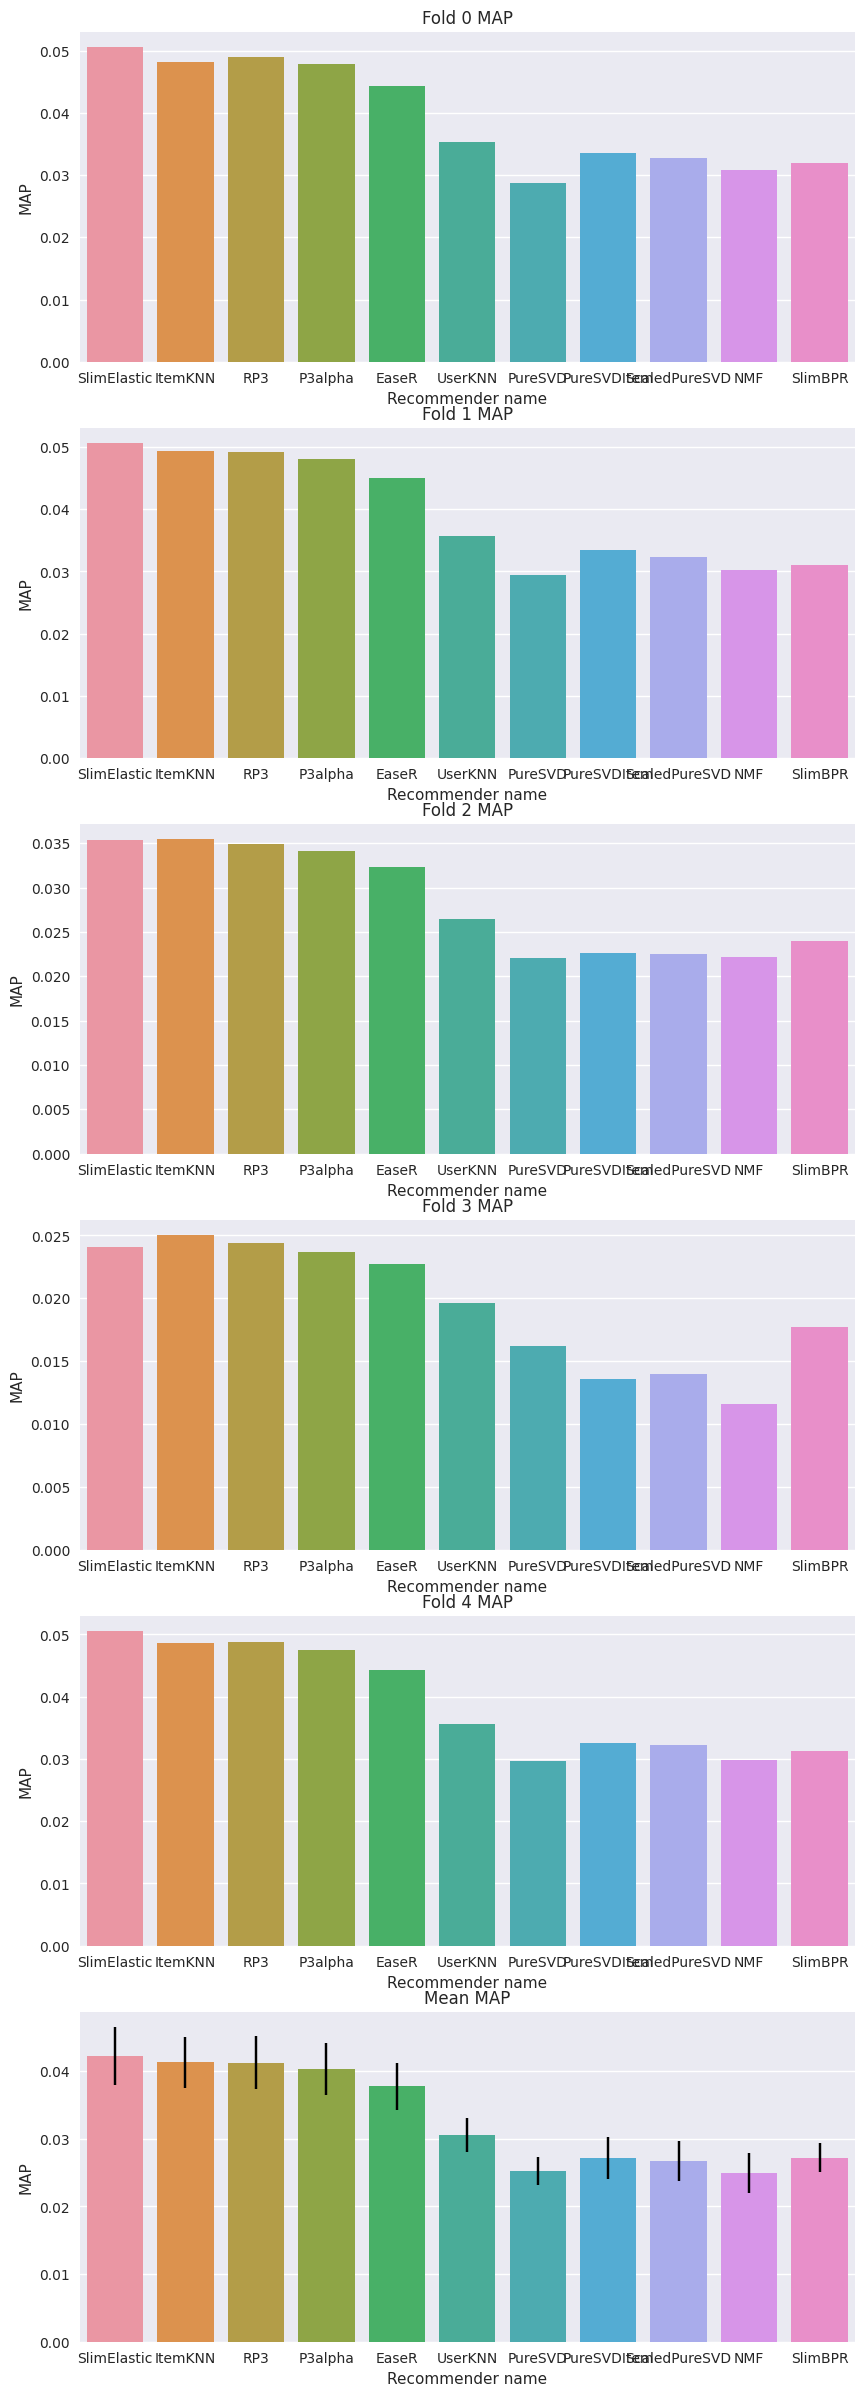

In [17]:
plt.style.use('seaborn-v0_8')
plt.rcParams.update({'lines.markeredgewidth': 1})

fig, axes = plt.subplots(len(folds) + 1, 1, figsize=(10, 30))

for i in range(len(folds)):
    sns.barplot(x=np.array(recommenders_map.columns), y=recommenders_map.loc[f'fold_{i}'].values, ax=axes[i])
    axes[i].set_title(f'Fold {i} MAP')
    axes[i].set_xlabel('Recommender name')
    axes[i].set_ylabel('MAP')
    
err_kws = {'fmt': 'o', 'markersize': 8, 'capsize': 20}
sns.barplot(x=mean_map.index, y=mean_map.values, yerr=conf_intervals, capsize=3, ax=axes[len(folds)])
axes[len(folds)].set_title('Mean MAP')
axes[len(folds)].set_xlabel('Recommender name')
axes[len(folds)].set_ylabel('MAP')
fig.show()

In [18]:
del folds
gc.collect()

336

# 10 Folds

In [19]:
folds = []

for i in tqdm.auto.tqdm(range(10)):
    fold_dict = {}
    fold_dict['URM_train'] = sps.load_npz(f'/kaggle/working/Recsys_Challenge_2023/models/10Folds/fold_{i}/URM_train.npz')
    fold_dict['URM_valid'] = sps.load_npz(f'/kaggle/working/Recsys_Challenge_2023/models/10Folds/fold_{i}/URM_valid.npz')
    fold_dict['Evaluator'] = EvaluatorHoldout(fold_dict['URM_valid'], cutoff_list=[10])
    
    recommender_item = ItemKNNCFRecommender(fold_dict['URM_train'])
    recommender_item.load_model(
        f'/kaggle/working/Recsys_Challenge_2023/models/10Folds/fold_{i}', 'item_knn.zip')
    fold_dict['ItemKNN'] = recommender_item

    recommender_user = UserKNNCFRecommender(fold_dict['URM_train'])
    recommender_user.load_model(
        f'/kaggle/working/Recsys_Challenge_2023/models/10Folds/fold_{i}', 'user_knn.zip')
    fold_dict['UserKNN'] = recommender_user

    recommender_rp3 = RP3betaRecommender(fold_dict['URM_train'])
    recommender_rp3.load_model(
        f'/kaggle/working/Recsys_Challenge_2023/models/10Folds/fold_{i}', 'rp3.zip')
    fold_dict['RP3'] = recommender_rp3

    recommender_p3a = P3alphaRecommender(fold_dict['URM_train'])
    recommender_p3a.load_model(
        f'/kaggle/working/Recsys_Challenge_2023/models/10Folds/fold_{i}', 'p3a.zip')
    fold_dict['P3alpha'] = recommender_p3a

    recommender_pure_svd = PureSVDRecommender(fold_dict['URM_train'])
    recommender_pure_svd.load_model(
        f'/kaggle/working/Recsys_Challenge_2023/models/10Folds/fold_{i}', 'pure_svd.zip')
    fold_dict['PureSVD'] = recommender_pure_svd

    recommender_pure_svd_item = PureSVDItemRecommender(fold_dict['URM_train'])
    recommender_pure_svd_item.load_model(
        f'/kaggle/working/Recsys_Challenge_2023/models/10Folds/fold_{i}', 'item_pure_svd.zip')
    fold_dict['PureSVDItem'] = recommender_pure_svd_item

    recommender_scaled_svd = ScaledPureSVDRecommender(fold_dict['URM_train'])
    recommender_scaled_svd.load_model(
        f'/kaggle/working/Recsys_Challenge_2023/models/10Folds/fold_{i}', 'pure_svd_scaled.zip')
    fold_dict['ScaledPureSVD'] = recommender_scaled_svd

    recommender_nmf = NMFRecommender(fold_dict['URM_train'])
    recommender_nmf.load_model(
        f'/kaggle/working/Recsys_Challenge_2023/models/10Folds/fold_{i}', 'nmf.zip')
    fold_dict['NMF'] = recommender_nmf

    recommender_slim_bpr = SLIM_BPR_Python(fold_dict['URM_train'])
    recommender_slim_bpr.load_model(
        f'/kaggle/working/Recsys_Challenge_2023/models/10Folds/fold_{i}', 'slim_bpr.zip')
    fold_dict['SlimBPR'] = recommender_slim_bpr

    recommender_slim = SLIMElasticNetRecommender(fold_dict['URM_train'])
    recommender_slim.load_model(
        f'/kaggle/working/Recsys_Challenge_2023/models/10Folds/fold_{i}', 'slim_elastic.zip')
    fold_dict['SlimElastic'] = recommender_slim
    
    recommender_ease_r = EASE_R_Recommender(fold_dict['URM_train'])
    recommender_ease_r.load_model(
        f'/kaggle/working/Recsys_Challenge_2023/models/10Folds/fold_{i}', 'ease_r.zip')
    fold_dict['EaseR'] = recommender_ease_r   
    
    folds.append(fold_dict)

  0%|          | 0/10 [00:00<?, ?it/s]

EvaluatorHoldout: Ignoring 4017 (30.8%) Users that have less than 1 test interactions
ItemKNNCFRecommender: URM Detected 490 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 176 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: Loading model from file '/kaggle/working/Recsys_Challenge_2023/models/10Folds/fold_0item_knn.zip'
ItemKNNCFRecommender: Loading complete
UserKNNCFRecommender: URM Detected 490 ( 3.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 176 ( 0.8%) items with no interactions.
UserKNNCFRecommender: Loading model from file '/kaggle/working/Recsys_Challenge_2023/models/10Folds/fold_0user_knn.zip'
UserKNNCFRecommender: Loading complete
RP3betaRecommender: URM Detected 490 ( 3.8%) users with no interactions.
RP3betaRecommender: URM Detected 176 ( 0.8%) items with no interactions.
RP3betaRecommender: Loading model from file '/kaggle/working/Recsys_Challenge_2023/models/10Folds/fold_0rp3.zip'
RP3betaRecommender: Loading complete


In [20]:
recommenders_map = {rec_lb: [] for rec_lb in recommenders_labels}

for fold in folds:

    for recommender in recommenders_labels:
        result_df, _ = fold['Evaluator'].evaluateRecommender(fold[recommender])
        recommenders_map[recommender].append(result_df.loc[10, 'MAP'])

recommenders_map = pd.DataFrame(recommenders_map, index=[f'fold_{i}' for i in range(len(folds))])
mean_map = recommenders_map.mean()
conf_intervals = recommenders_map.apply(lambda col: np.std(col) * 1.96 / len(folds))

EvaluatorHoldout: Processed 9007 (100.0%) in 11.54 sec. Users per second: 781
EvaluatorHoldout: Processed 9007 (100.0%) in 7.80 sec. Users per second: 1155
EvaluatorHoldout: Processed 9007 (100.0%) in 7.97 sec. Users per second: 1130
EvaluatorHoldout: Processed 9007 (100.0%) in 7.68 sec. Users per second: 1172
EvaluatorHoldout: Processed 9007 (100.0%) in 13.43 sec. Users per second: 671
EvaluatorHoldout: Processed 9007 (100.0%) in 11.31 sec. Users per second: 797
EvaluatorHoldout: Processed 9007 (100.0%) in 9.25 sec. Users per second: 974
EvaluatorHoldout: Processed 9007 (100.0%) in 13.33 sec. Users per second: 676
EvaluatorHoldout: Processed 9007 (100.0%) in 11.32 sec. Users per second: 795
EvaluatorHoldout: Processed 9007 (100.0%) in 10.09 sec. Users per second: 893
EvaluatorHoldout: Processed 9007 (100.0%) in 9.36 sec. Users per second: 963
EvaluatorHoldout: Processed 8987 (100.0%) in 11.24 sec. Users per second: 800
EvaluatorHoldout: Processed 8987 (100.0%) in 7.86 sec. Users per s

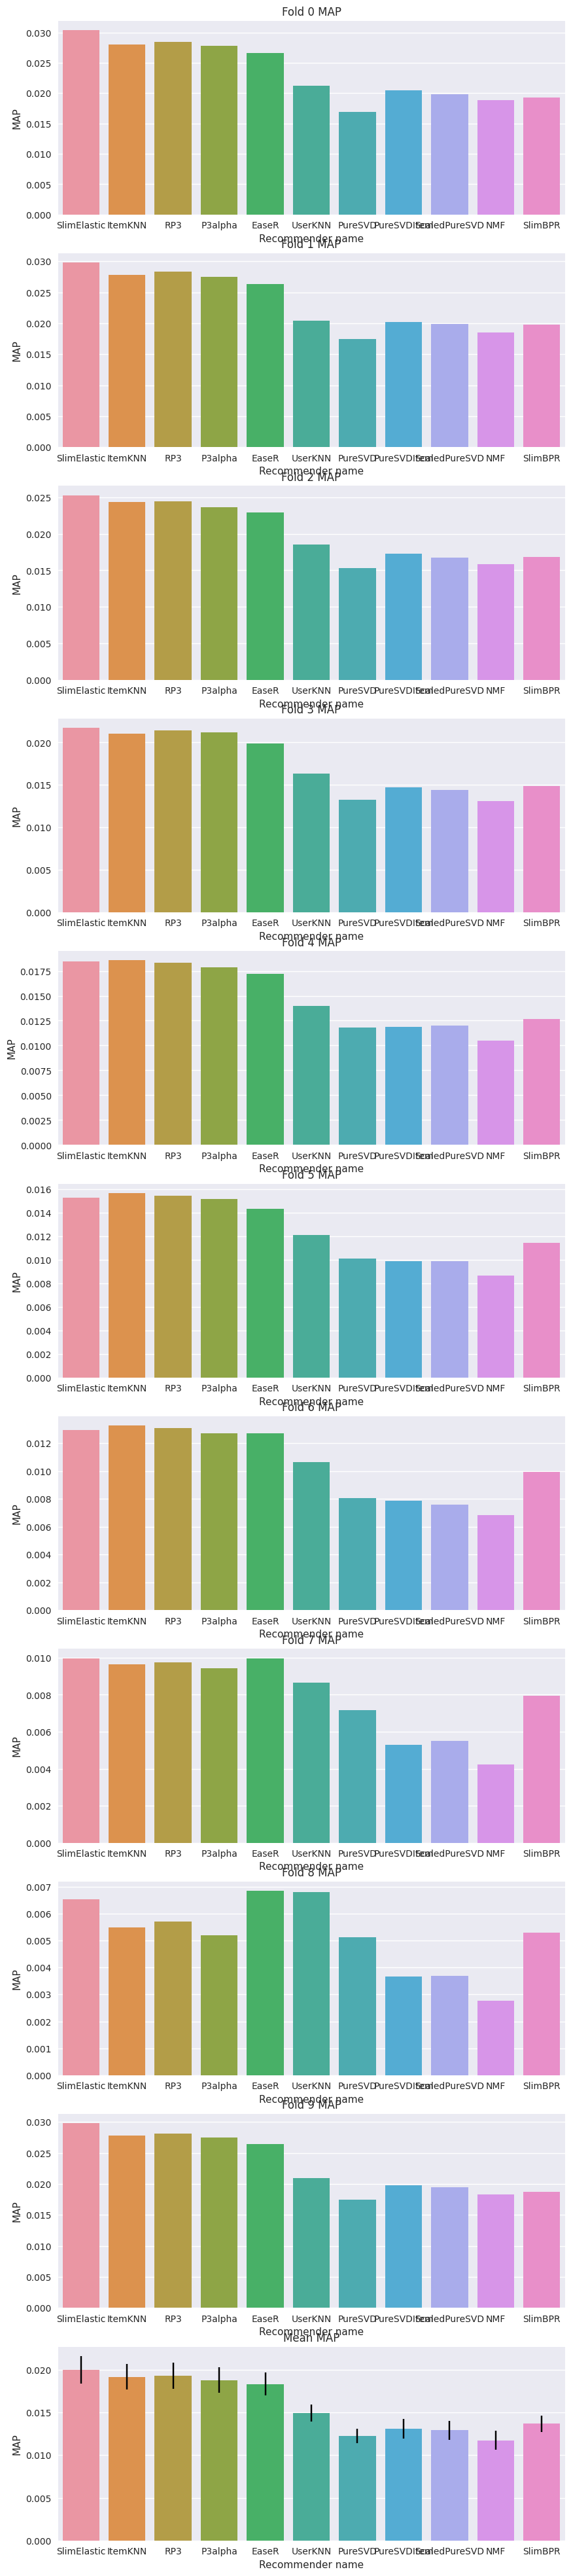

In [21]:
fig, axes = plt.subplots(len(folds) + 1, 1, figsize=(10, 50))

for i in range(len(folds)):
    sns.barplot(x=np.array(recommenders_map.columns), y=recommenders_map.loc[f'fold_{i}'].values, ax=axes[i])
    axes[i].set_title(f'Fold {i} MAP')
    axes[i].set_xlabel('Recommender name')
    axes[i].set_ylabel('MAP')
    
err_kws = {'fmt': 'o', 'markersize': 8, 'capsize': 20}
sns.barplot(x=mean_map.index, y=mean_map.values, yerr=conf_intervals, capsize=3, ax=axes[len(folds)])
axes[len(folds)].set_title('Mean MAP')
axes[len(folds)].set_xlabel('Recommender name')
axes[len(folds)].set_ylabel('MAP')
fig.show()